<a href="https://colab.research.google.com/github/donw385/DS-Unit-4-Sprint-1-Tree-Ensembles/blob/master/module1-decision-trees/LS_DS_411A_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Tree Ensembles_ 

# Decision Trees

### Pre-read / pre-watch
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [How a Russian mathematician constructed a decision tree - by hand - to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)


### Categorical encoding for trees

#### Good reads
- [Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)

#### Some options
- [category_encoders.target_encoder.OrdinalEncoder](http://contrib.scikit-learn.org/categorical-encoding/ordinal.html)
- [category_encoders.target_encoder.TargetEncoder](http://contrib.scikit-learn.org/categorical-encoding/targetencoder.html)
- [sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) + [sklearn.compose.ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer)
- [sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) + [sklearn-pandas](https://github.com/scikit-learn-contrib/sklearn-pandas)
- [kaggler.preprocessing.data.OneHotEncoder(min_obs=...)](https://pythonhosted.org/Kaggler/kaggler.preprocessing.html#kaggler.preprocessing.data.OneHotEncoder)
- [Create your own scikit-learn compatible transformers!](https://github.com/PacktPublishing/Hands-On-Machine-Learning-with-Python-and-Scikit-Learn/blob/master/code/Feature%20Engineering.ipynb)

### Libraries

This notebook optionally uses the [dtreeviz](https://explained.ai/decision-tree-viz/) library for decision tree visualizations.

It is easy to install on Google Colab: `!pip install dtreeviz`

But the [installation instructions](https://github.com/parrt/dtreeviz#install) are harder on Mac or Windows. 

So you have several options with this notebook:
1. Run on Google Colab
2. Install dtreeviz on your system
3. Skip the cells with dtreeviz

In [1]:
!pip install dtreeviz

  Stored in directory: /root/.cache/pip/wheels/4c/3f/87/b2c828617d1bd181145fbaf41129e4c82fa8d9a98082701e00
Successfully built dtreeviz


This notebook also uses the [category_encoders](https://github.com/scikit-learn-contrib/categorical-encoding) library.

To install on Google Colab: `!pip install category_encoders`

To install with Anaconda: `!conda install -c conda-forge category_encoders`


In [2]:
!pip install category_encoders

    100% |████████████████████████████████| 61kB 2.4MB/s 


## Play Tennis

We'll reproduce the "Play Tennis" example from Ross Quinlan's 1986 paper, [Induction of Decison Trees](https://link.springer.com/content/pdf/10.1007%2FBF00116251.pdf).

[According to Wikipedia](https://en.wikipedia.org/wiki/Ross_Quinlan), "John Ross Quinlan is a computer science researcher in data mining and decision theory. He has contributed extensively to the development of decision tree algorithms, including inventing the canonical C4.5 and ID3 algorithms."

***"Table 1 shows a small training set"***

In [3]:
import pandas as pd

columns = 'No. Outlook Temperature Humidity Windy Class'.split()

raw = """1 sunny hot high false N
2 sunny hot high true N
3 overcast hot high false P
4 rain mild high false P
5 rain cool normal false P
6 rain cool normal true N
7 overcast cool normal true P
8 sunny mild high false N
9 sunny cool normal false P
10 rain mild normal false P
11 sunny mild normal true P
12 overcast mild high true P
13 overcast hot normal false P
14 rain mild high true N"""

data = [row.split() for row in raw.split('\n')]

tennis = pd.DataFrame(data, columns=columns).set_index('No.')

tennis

Outlook Temperature Humidity  Windy Class
No.                                            
1       sunny         hot     high  false     N
2       sunny         hot     high   true     N
3    overcast         hot     high  false     P
4        rain        mild     high  false     P
5        rain        cool   normal  false     P
6        rain        cool   normal   true     N
7    overcast        cool   normal   true     P
8       sunny        mild     high  false     N
9       sunny        cool   normal  false     P
10       rain        mild   normal  false     P
11      sunny        mild   normal   true     P
12   overcast        mild     high   true     P
13   overcast         hot   normal  false     P
14       rain        mild     high   true     N

In [0]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

***"A decision tree that correctly classifies each object in the training set is given in Figure 2."***

<img src="https://i.imgur.com/RD7d0u0.png" height="300">

### Explore the data
(and compare to Figure 2 above)

In this dataset, the tennis player decided to play on 9 days, and decided not to on 5 days.

In [4]:
tennis['Class'] = (tennis['Class'] == 'P').astype(int)
tennis['Class'].value_counts()

1    9
0    5
Name: Class, dtype: int64

The tennis player played on 4 overcast days, 3 rainy days, and 2 sunny days.

In [5]:
tennis.groupby('Outlook')['Class'].sum()

Outlook
overcast    4
rain        3
sunny       2
Name: Class, dtype: int64

On sunny days, the tennis player's decision depends on the humidity. (The Outlook and Humidity features interact.)

In [6]:
tennis[tennis['Outlook']=='sunny'].groupby('Humidity')['Class'].sum()

Humidity
high      0
normal    2
Name: Class, dtype: int64

On rainy days, the tennis player's decision depends on the wind. (The Outlook and Windy features interact.)

In [7]:
tennis[tennis['Outlook']=='rain'].groupby('Windy')['Class'].sum()

Windy
false    3
true     0
Name: Class, dtype: int64

### Train a Decision Tree
The tree has 100% accuracy

In [8]:
from sklearn.tree import DecisionTreeClassifier

X = pd.get_dummies(tennis.drop(columns='Class'))
y = tennis['Class']

dt = DecisionTreeClassifier()
dt.fit(X, y)
dt.score(X, y)

1.0

### Visualize the tree
With dtreeviz:

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


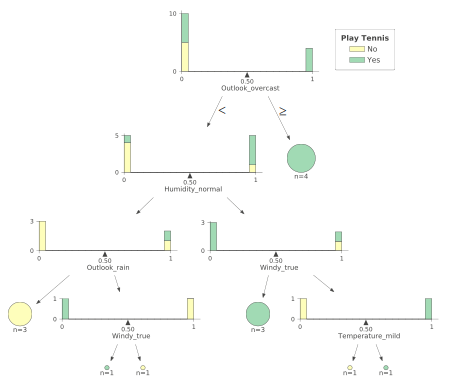

In [9]:
from dtreeviz.trees import dtreeviz

dtreeviz(dt, X, y, 
         target_name='Play Tennis',
         feature_names=X.columns, 
         class_names=['No', 'Yes'])

With scikit-learn:

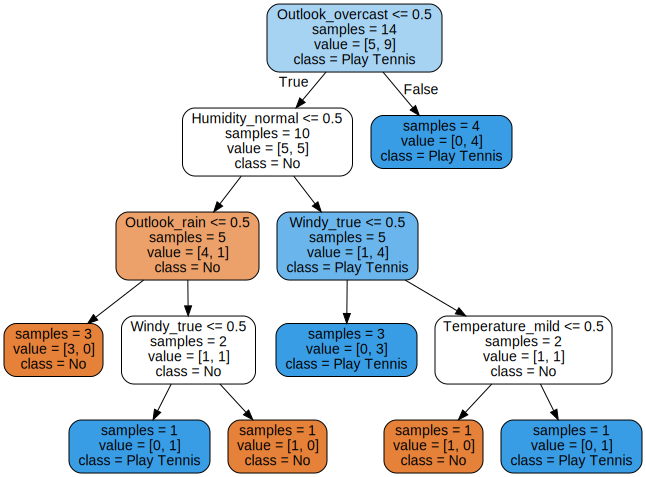

In [10]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X.columns, 
                           class_names=['No', 'Play Tennis'],   
                           filled=True, impurity=False, rounded=True)
graphviz.Source(dot_data)

### Compare to Logistic Regression
Logistic Regression has lower accuracy here:

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs')
lr.fit(X, y)
lr.score(X, y)

0.8571428571428571

The Logistic Regression model has these coefficients:

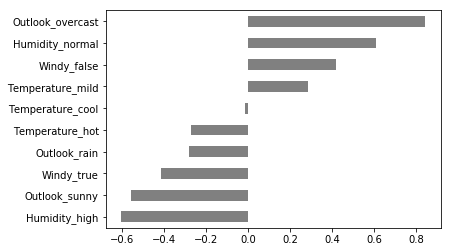

In [12]:
pd.Series(lr.coef_[0], X.columns).sort_values().plot.barh(color='grey');

### What if we use "Ordinal" encoding instead of One-Hot?

The "ordinal" encoding is applied arbitrarily here.

The decision tree still has 100% accuracy.

In [13]:
import category_encoders as ce

encoder = ce.OrdinalEncoder()
X = encoder.fit_transform(tennis.drop(columns='Class'))
y = tennis['Class']

dt = DecisionTreeClassifier()
dt.fit(X, y)
dt.score(X, y)

1.0

A tree's [feature importances](https://explained.ai/rf-importance/index.html#3) are non-negative. They have magnitude but no direction. 

"Outlook" is the most important feature in this model.

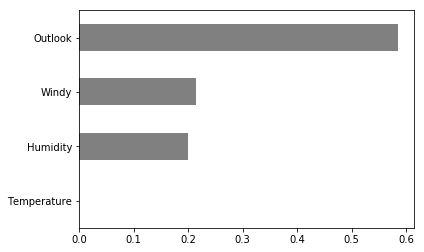

In [14]:
pd.Series(dt.feature_importances_, X.columns).sort_values().plot.barh(color='grey');

With the arbitrary "ordinal" encoding, the Logistic Regression accuracy decreases to 64% (compared to 86% with One-Hot Encoding).

In [15]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X, y)
lr.score(X, y)

0.6428571428571429

Why? Because now the relatioship between some features and target are not monotonic. 

We can look this, one feature at a time.

In [16]:
Xy = pd.concat([X, y], axis='columns')
Xy.groupby('Outlook')['Class'].sum()

Outlook
1    2
2    4
3    3
Name: Class, dtype: int64

In [17]:
Xy.groupby('Temperature')['Class'].sum()

Temperature
1    2
2    4
3    3
Name: Class, dtype: int64

In [18]:
Xy.groupby('Humidity')['Class'].sum()

Humidity
1    3
2    6
Name: Class, dtype: int64

In [19]:
Xy.groupby('Windy')['Class'].sum()

Windy
1    6
2    3
Name: Class, dtype: int64

The "Humidity" and "Windy" features have monotnic relationships with the target. The other two features do not. This is shown in the model's coefficients.

We know that the "Outlook" feature is important in this dataset, but Logistic Regression cannot model it with an arbitrary "ordinal" encoding.

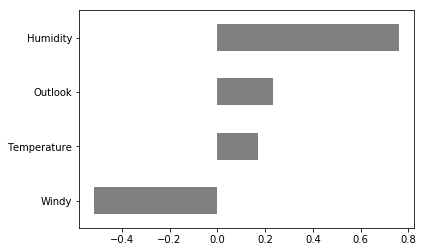

In [20]:
pd.Series(lr.coef_[0], X.columns).sort_values().plot.barh(color='grey');

See the links at the top of this notebook to learn more about categorical encoding for trees.

## Shallow trees are good for fast, first baselines, and to look for "leakage"

[Xavier Amatriain recommends,](https://www.quora.com/What-are-some-best-practices-for-training-machine-learning-models/answer/Xavier-Amatriain)

"Make sure your training features do not contain data from the “future” (aka time traveling). While this might be easy and obvious in some cases, it can get tricky. ... If your test metric becomes really good all of the sudden, ask yourself what you might be doing wrong. Chances are you are time travelling or overfitting in some way."

We can test this with the [UCI repository's Bank Marketing dataset](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). It has a feature which leaks information from the future and should be dropped:

"11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input ... should be discarded if the intention is to have a realistic predictive model."

So let's download the data ...

In [21]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
%cd bank-additional

--2019-04-22 20:49:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 434.15K  1.29MB/s    in 0.3s    

2019-04-22 20:49:31 (1.29 MB/s) - ‘bank-additional.zip’ saved [444572/444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/

... and train a shallow tree baseline, without dropping the `duration` feature.

In [22]:
import category_encoders as ce
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv('bank-additional-full.csv', sep=';')
X = df.drop(columns='y')
y = df['y'] == 'yes'

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    DecisionTreeClassifier(max_depth=2)
)

cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

array([0.85309963, 0.86704028, 0.85589586, 0.85229795, 0.86402673])

This baseline has a ROC AUC score above 0.85, and it uses the `duration` feature, as well as `nr.employed`, a "social and economic context attribute" for "number of employees - quarterly indicator."

In [23]:
pipe.fit(X_train, y_train)
tree = pipe.named_steps['decisiontreeclassifier']
encoder = pipe.named_steps['onehotencoder']
feature_names = encoder.transform(X_train).columns
feature_names[tree.feature_importances_ > 0]

Index(['duration', 'nr.employed'], dtype='object')

We can visualize the tree:

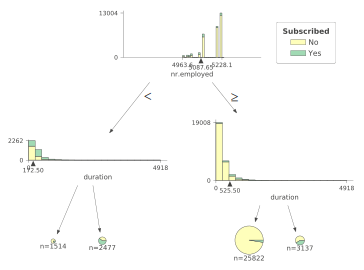

In [24]:
from dtreeviz.trees import dtreeviz

class_names = ['No', 'Yes']
dtreeviz(tree, encoder.transform(X_train), y_train, 
         target_name='Subscribed',
         feature_names=list(feature_names), 
         class_names=class_names)

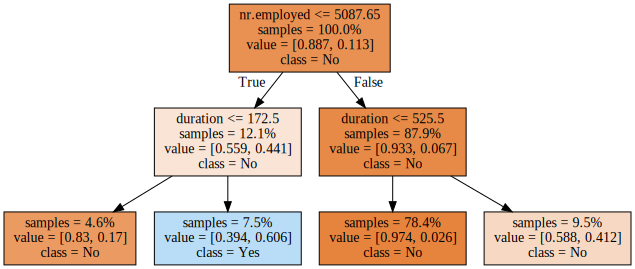

In [25]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=feature_names, class_names=class_names, 
                           filled=True, impurity=False, proportion=True)

graphviz.Source(dot_data)

### When the `duration` feature is dropped, 
then the ROC AUC score drops from ~0.85 to ~0.75

In [26]:
X_train = X_train.drop(columns='duration')
cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')

array([0.75192356, 0.73669375, 0.7473569 , 0.73692904, 0.74700667])

### ROC AUC

[Wikipedia explains,](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) "A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings."

ROC AUC is the area under the ROC curve. [It can be interpreted](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it) as "the expectation that a uniformly drawn random positive is ranked before a uniformly drawn random negative." 

ROC AUC measures how well a classifier ranks predicted probabilities. It ranges from 0 to 1. A naive majority class baseline will have an ROC AUC score of 0.5. 

Area under the Receiver Operating Characteristic curve: 0.7404622305997627


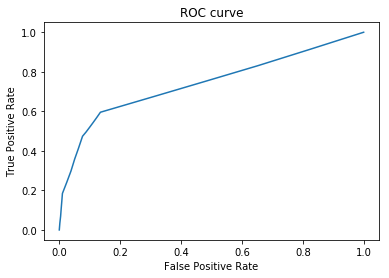

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_predict

y_pred_proba = cross_val_predict(pipe, X_train, y_train, cv=5, n_jobs=-1, 
                                 method='predict_proba')[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(y_train, y_pred_proba))

In [28]:
pd.DataFrame({'False Positive Rate': fpr, 
              'True Positive Rate': tpr, 
              'Threshold': thresholds})

False Positive Rate  True Positive Rate  Threshold
0              0.000000            0.000000   1.714088
1              0.001847            0.034752   0.714088
2              0.004344            0.068966   0.709202
3              0.006225            0.107220   0.693569
4              0.008174            0.143588   0.692588
5              0.010295            0.184537   0.690387
6              0.024454            0.240571   0.361076
7              0.038306            0.297683   0.356931
8              0.050619            0.358836   0.354826
9              0.062624            0.411099   0.353764
10             0.076339            0.473869   0.350555
11             0.088036            0.495420   0.212000
12             0.100144            0.520205   0.207995
13             0.110986            0.542834   0.207228
14             0.122956            0.568427   0.206138
15             0.135201            0.595366   0.204784
16             0.309084            0.674030   0.056513
17             0.480778            0.752155   0.056432
18             0.652473            0.830819   0.056345
19             0.825809            0.914601   0.055633
20             1.000000            1.000000   0.055433

In [29]:
!pip install kaggle

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [31]:
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/


env: KAGGLE_CONFIG_DIR=/content/drive/My Drive/


In [32]:
!kaggle competitions download -c ds2-tree-ensembles

  0% 0.00/313k [00:00<?, ?B/s]
100% 313k/313k [00:00<00:00, 41.0MB/s]
  0% 0.00/3.57M [00:00<?, ?B/s]
100% 3.57M/3.57M [00:00<00:00, 118MB/s]
 95% 166M/174M [00:00<00:00, 154MB/s]
100% 174M/174M [00:01<00:00, 171MB/s]
  0% 0.00/4.86M [00:00<?, ?B/s]
100% 4.86M/4.86M [00:00<00:00, 79.8MB/s]


In [34]:
!unzip test_features.csv.zip


Archive:  test_features.csv.zip
  inflating: test_features.csv       


In [35]:
!unzip train_features.csv.zip

Archive:  train_features.csv.zip
  inflating: train_features.csv      


In [36]:
!unzip train_labels.csv.zip

Archive:  train_labels.csv.zip
  inflating: train_labels.csv        


In [37]:
train_df = pd.read_csv('train_features.csv')


id  member_id  loan_amnt  funded_amnt        term int_rate  \
0        1246716        NaN    22000.0      22000.0   36 months    5.32%   
1        1678744        NaN    10000.0      10000.0   36 months    5.32%   
2        1149018        NaN     7000.0       7000.0   36 months    6.97%   
3        1349740        NaN     1400.0       1400.0   36 months   13.67%   
4        1234365        NaN    19200.0      19200.0   36 months    8.18%   
5        1769306        NaN    10000.0      10000.0   36 months   15.59%   
6        1632300        NaN     7000.0       7000.0   36 months   15.31%   
7        1135319        NaN    15000.0      15000.0   36 months   16.02%   
8        1238630        NaN    19400.0      19400.0   60 months   18.99%   
9        1525617        NaN    14400.0      14400.0   60 months   11.47%   
10       1270676        NaN    10000.0      10000.0   36 months    7.39%   
11       1601797        NaN     4800.0       4800.0   36 months   10.99%   
12       1622288        NaN    21600.0      21600.0   60 months   13.98%   
13       1663436        NaN    20000.0      20000.0   60 months   23.99%   
14       1399062        NaN    18000.0      18000.0   36 months   17.27%   
15       1300927        NaN     1200.0       1200.0   36 months   12.39%   
16       1619838        NaN    14075.0      14075.0   36 months   28.69%   
17       2082199        NaN    15000.0      15000.0   36 months   14.16%   
18       1533332        NaN     6000.0       6000.0   36 months   12.79%   
19       1336506        NaN    20000.0      20000.0   60 months   11.99%   
20       1253757        NaN    24500.0      24500.0   36 months    6.17%   
21       1670439        NaN    10000.0      10000.0   36 months    9.99%   
22       2190315        NaN    17000.0      17000.0   36 months   10.16%   
23       2287437        NaN     8000.0       8000.0   36 months   13.65%   
24       2230141        NaN    18000.0      18000.0   36 months    8.39%   
25       1244176        NaN    24000.0      24000.0   36 months   12.39%   
26       2249480        NaN     5000.0       5000.0   36 months    5.32%   
27       1481986        NaN    21000.0      21000.0   60 months   19.99%   
28       2111218        NaN    10000.0      10000.0   36 months   10.91%   
29       1662708        NaN     1500.0       1500.0   36 months    5.32%   
...          ...        ...        ...          ...         ...      ...   
1309427  1151463        NaN     6400.0       6400.0   36 months   10.99%   
1309428  1637739        NaN     2400.0       2400.0   36 months   20.00%   
1309429  1220950        NaN    12850.0      12850.0   60 months   18.55%   
1309430  2138552        NaN     7000.0       7000.0   36 months   10.49%   
1309431  1860824        NaN    14400.0      14400.0   36 months   12.12%   
1309432  1501746        NaN     8800.0       8800.0   36 months   13.05%   
1309433  1483801        NaN    25000.0      25000.0   60 months   11.47%   
1309434  1270879        NaN    16450.0      16450.0   36 months   11.99%   
1309435  1718870        NaN     5600.0       5600.0   36 months   11.99%   
1309436  1672547        NaN    23850.0      23850.0   60 months   15.80%   
1309437  1980044        NaN    12000.0      12000.0   60 months   15.61%   
1309438  1932039        NaN    12000.0      12000.0   36 months   11.99%   
1309439  1725765        NaN    22000.0      22000.0   60 months   12.69%   
1309440  2008297        NaN    25000.0      25000.0   36 months    5.32%   
1309441  1140371        NaN     9000.0       9000.0   36 months    7.89%   
1309442  1027284        NaN     6000.0       6000.0   36 months    9.67%   
1309443  2224892        NaN    19200.0      19200.0   60 months    9.99%   
1309444  1704752        NaN    35000.0      35000.0   36 months   18.25%   
1309445  1159539        NaN     8000.0       8000.0   36 months    9.44%   
1309446  2179422        NaN    14600.0      14600.0   36 months   18.54%   
1309447  1960993        NaN    10500.0      10500.0   60 month

In [38]:
train_df.shape

(1309457, 103)

In [41]:
train_df

id  member_id  loan_amnt  funded_amnt        term int_rate  \
0        1246716        NaN    22000.0      22000.0   36 months    5.32%   
1        1678744        NaN    10000.0      10000.0   36 months    5.32%   
2        1149018        NaN     7000.0       7000.0   36 months    6.97%   
3        1349740        NaN     1400.0       1400.0   36 months   13.67%   
4        1234365        NaN    19200.0      19200.0   36 months    8.18%   
5        1769306        NaN    10000.0      10000.0   36 months   15.59%   
6        1632300        NaN     7000.0       7000.0   36 months   15.31%   
7        1135319        NaN    15000.0      15000.0   36 months   16.02%   
8        1238630        NaN    19400.0      19400.0   60 months   18.99%   
9        1525617        NaN    14400.0      14400.0   60 months   11.47%   
10       1270676        NaN    10000.0      10000.0   36 months    7.39%   
11       1601797        NaN     4800.0       4800.0   36 months   10.99%   
12       1622288        NaN    21600.0      21600.0   60 months   13.98%   
13       1663436        NaN    20000.0      20000.0   60 months   23.99%   
14       1399062        NaN    18000.0      18000.0   36 months   17.27%   
15       1300927        NaN     1200.0       1200.0   36 months   12.39%   
16       1619838        NaN    14075.0      14075.0   36 months   28.69%   
17       2082199        NaN    15000.0      15000.0   36 months   14.16%   
18       1533332        NaN     6000.0       6000.0   36 months   12.79%   
19       1336506        NaN    20000.0      20000.0   60 months   11.99%   
20       1253757        NaN    24500.0      24500.0   36 months    6.17%   
21       1670439        NaN    10000.0      10000.0   36 months    9.99%   
22       2190315        NaN    17000.0      17000.0   36 months   10.16%   
23       2287437        NaN     8000.0       8000.0   36 months   13.65%   
24       2230141        NaN    18000.0      18000.0   36 months    8.39%   
25       1244176        NaN    24000.0      24000.0   36 months   12.39%   
26       2249480        NaN     5000.0       5000.0   36 months    5.32%   
27       1481986        NaN    21000.0      21000.0   60 months   19.99%   
28       2111218        NaN    10000.0      10000.0   36 months   10.91%   
29       1662708        NaN     1500.0       1500.0   36 months    5.32%   
30       1909978        NaN    18000.0      18000.0   36 months    6.62%   
31       1576605        NaN    25000.0      25000.0   60 months   13.33%   
32       1185753        NaN     6000.0       6000.0   36 months   11.14%   
33       1964238        NaN     6000.0       6000.0   36 months   13.53%   
34       2256177        NaN     1800.0       1800.0   36 months   16.29%   
35       1633269        NaN     7000.0       7000.0   36 months   11.99%   
36       1005642        NaN    35000.0      35000.0   36 months    9.17%   
37       2302359        NaN    11375.0      11375.0   36 months   17.57%   
38       1792560        NaN     6000.0       6000.0   36 months   13.49%   
39       1120508        NaN    35000.0      35000.0   60 months   17.97%   
40       2004393        NaN     5000.0       5000.0   36 months   14.85%   
41       1174967        NaN     7500.0       7500.0   36 months    6.99%   
42       1449221        NaN    20000.0      20000.0   36 months   11.99%   
43       1417071        NaN    30000.0      30000.0   36 months   23.40%   
44       1719609        NaN     6400.0       6400.0   36 months   11.49%   
45       2253129        NaN     1600.0       1600.0   36 months   12.49%   
46       2059992        NaN    35000.0      35000.0   60 months   22.74%   
47       1999445        NaN    10500.0      10500.0   36 months   11.39%   
48       1600105        NaN    29950.0      29950.0   60 months   18.49%   
49       2085454        NaN    20000.0      20000.0   36 months   20.00%   
50       1912799        NaN    20000.0      20000.0   36 months   11.49%   
51       1099189        NaN     9400.0       9400.0   36 month

In [45]:
train_df.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'application_type', 'annual_inc_joint', 'dti_joint',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m',
       'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeof

In [46]:
train_labels_df = pd.read_csv('train_labels.csv')
train_labels_df

id  charged_off
0        1246716            0
1        1678744            0
2        1149018            1
3        1349740            0
4        1234365            0
5        1769306            0
6        1632300            1
7        1135319            0
8        1238630            1
9        1525617            0
10       1270676            0
11       1601797            0
12       1622288            0
13       1663436            0
14       1399062            0
15       1300927            1
16       1619838            1
17       2082199            0
18       1533332            0
19       1336506            0
20       1253757            0
21       1670439            0
22       2190315            1
23       2287437            0
24       2230141            0
25       1244176            0
26       2249480            0
27       1481986            1
28       2111218            0
29       1662708            0
30       1909978            0
31       1576605            0
32       1185753            0
33       1964238            0
34       2256177            0
35       1633269            1
36       1005642            0
37       2302359            1
38       1792560            0
39       1120508            0
40       2004393            0
41       1174967            0
42       1449221            1
43       1417071            0
44       1719609            1
45       2253129            0
46       2059992            0
47       1999445            0
48       1600105            1
49       2085454            0
50       1912799            0
51       1099189            0
52       2317829            0
53       1686715            1
54       1061574            0
55       1027997            0
56       1158848            0
57       1552197            0
58       1645560            0
59       1658293            0
60       1584368            0
61       1485891            0
62       1292128            1
63       1915479            0
64       2108619            1
65       1132189            0
66       1467337            1
67       1802999            0
68       2294536            0
69       1800382            1
70       1495440            0
71       2146646            0
72       1088115            1
73       1861532            0
74       2229686            0
75       1995118            0
76       1366815            0
77       1527086            1
78       1636372            0
79       1355807            0
80       1870738            0
81       1630095            1
82       1813245            0
83       1658756            0
84       2247587            0
85       2163550            0
86       1235843            0
87       1069392            0
88       1870786            0
89       1420600            0
90       1584681            0
91       1505837            0
92       1313384            0
93       1872437            0
94       2036533            0
95       1289628            0
96       1144182            0
97       1600896            0
98       1812636            0
99       1147391            1
100      1742833            0
101      2165992            0
102      1581069            0
103      1850532            0
104      1771470            1
105      1923713            1
106      1457287            0
107      1381704            0
108      1766847            0
109      1452905            0
110      1239305            1
111      1881322            0
112      1195453            0
113      1297313            0
114      1425085            0
115      1265155            1
116      2150000            0
117      1909586            0
118      1870408            0
119      1835498            0
120      1877211            0
121      1865130            0
122      1924349            0
123      1428419            0
124      1675134            0
125      1277995            0
126      1635224            0
127      1278184            0
128      1751854            0
129      2229696            0
130      1790070            0
131      1622993            0
132      2171268        

In [47]:
train_labels_df.shape

(1309457, 2)

In [48]:
test_df = pd.read_csv('test_features.csv')
test_df

id  member_id  loan_amnt  funded_amnt        term int_rate  \
0      2264704        NaN    20000.0      20000.0   36 months    8.18%   
1      1896343        NaN     4000.0       4000.0   36 months   13.99%   
2      2077525        NaN    10000.0      10000.0   36 months   10.99%   
3      1846827        NaN    12000.0      12000.0   60 months   14.31%   
4      1210251        NaN     2400.0       2400.0   36 months    6.72%   
5      1245569        NaN     6000.0       6000.0   36 months    9.67%   
6      1182529        NaN     3600.0       3600.0   36 months   20.80%   
7      1490934        NaN    13000.0      13000.0   36 months   12.05%   
8      1622025        NaN    10000.0      10000.0   36 months    9.99%   
9      2103304        NaN     3500.0       3500.0   36 months    7.89%   
10     1429592        NaN     3000.0       3000.0   36 months   11.99%   
11     1631505        NaN     4000.0       4000.0   36 months   19.99%   
12     2333381        NaN    10000.0      10000.0   36 months   12.99%   
13     2252511        NaN    12000.0      12000.0   36 months   15.59%   
14     1690625        NaN    10000.0      10000.0   36 months   23.88%   
15     1995421        NaN    10000.0      10000.0   36 months   19.05%   
16     2165793        NaN    12000.0      12000.0   60 months   12.99%   
17     2069223        NaN    11950.0      11950.0   60 months   17.57%   
18     2271648        NaN     4200.0       4200.0   36 months   16.55%   
19     1317797        NaN     5500.0       5500.0   36 months   14.47%   
20     1664081        NaN    10000.0      10000.0   36 months    7.90%   
21     1856009        NaN     1000.0       1000.0   36 months   10.99%   
22     1756402        NaN     8000.0       8000.0   36 months    9.75%   
23     1112966        NaN    35000.0      35000.0   36 months   16.29%   
24     1523660        NaN    16000.0      16000.0   36 months    9.17%   
25     2001692        NaN     7825.0       7825.0   36 months    6.92%   
26     1442011        NaN     1500.0       1500.0   36 months   14.64%   
27     1539639        NaN    30000.0      30000.0   36 months   12.99%   
28     1158465        NaN    35000.0      35000.0   60 months   20.99%   
29     2277364        NaN    10200.0      10200.0   60 months   17.86%   
30     1108786        NaN     6000.0       6000.0   36 months    8.39%   
31     1815045        NaN    10000.0      10000.0   36 months    8.18%   
32     1575514        NaN    12000.0      12000.0   36 months   10.49%   
33     1113516        NaN     8000.0       8000.0   36 months   14.35%   
34     1350997        NaN    11000.0      11000.0   36 months   12.35%   
35     1730001        NaN    15000.0      15000.0   60 months   16.20%   
36     1740880        NaN     6500.0       6500.0   36 months    9.17%   
37     2079420        NaN     1500.0       1500.0   36 months   11.49%   
38     1026950        NaN    18000.0      18000.0   60 months   15.61%   
39     1858007        NaN    28000.0      28000.0   60 months   12.12%   
40     1316319        NaN    18000.0      18000.0   60 months   25.28%   
41     1195759        NaN    10000.0      10000.0   36 months   15.99%   
42     1639945        NaN    10000.0      10000.0   36 months    8.39%   
43     2324629        NaN    15000.0      15000.0   36 months   11.53%   
44     1777117        NaN     4375.0       4375.0   36 months   21.45%   
45     2107282        NaN     8500.0       8500.0   36 months    8.24%   
46     1106990        NaN    25000.0      25000.0   36 months   16.55%   
47     1954308        NaN     2400.0       2400.0   36 months   15.59%   
48     1926155        NaN     4200.0       4200.0   36 months   12.29%   
49     2201062        NaN    11000.0      11000.0   36 months   12.12%   
50     1788667        NaN    15000.0      15000.0   36 months    6.92%   
51     1876197        NaN     5000.0       5000.0   36 months    9.17%   
52     2127886        NaN    30000.0      30000.0   60 months   12.69%   
53     1553289  

In [49]:
sample = pd.read_csv('sample_submission.csv')
sample

id  charged_off
0      2264704          0.5
1      1896343          0.5
2      2077525          0.5
3      1846827          0.5
4      1210251          0.5
5      1245569          0.5
6      1182529          0.5
7      1490934          0.5
8      1622025          0.5
9      2103304          0.5
10     1429592          0.5
11     1631505          0.5
12     2333381          0.5
13     2252511          0.5
14     1690625          0.5
15     1995421          0.5
16     2165793          0.5
17     2069223          0.5
18     2271648          0.5
19     1317797          0.5
20     1664081          0.5
21     1856009          0.5
22     1756402          0.5
23     1112966          0.5
24     1523660          0.5
25     2001692          0.5
26     1442011          0.5
27     1539639          0.5
28     1158465          0.5
29     2277364          0.5
30     1108786          0.5
31     1815045          0.5
32     1575514          0.5
33     1113516          0.5
34     1350997          0.5
35     1730001          0.5
36     1740880          0.5
37     2079420          0.5
38     1026950          0.5
39     1858007          0.5
40     1316319          0.5
41     1195759          0.5
42     1639945          0.5
43     2324629          0.5
44     1777117          0.5
45     2107282          0.5
46     1106990          0.5
47     1954308          0.5
48     1926155          0.5
49     2201062          0.5
50     1788667          0.5
51     1876197          0.5
52     2127886          0.5
53     1553289          0.5
54     1257555          0.5
55     1052625          0.5
56     1831674          0.5
57     1450000          0.5
58     1985765          0.5
59     1972564          0.5
60     1812405          0.5
61     1836199          0.5
62     1325343          0.5
63     2210419          0.5
64     1340439          0.5
65     1367023          0.5
66     1001904          0.5
67     1162939          0.5
68     1905664          0.5
69     1505567          0.5
70     2009976          0.5
71     1206105          0.5
72     1481274          0.5
73     1558144          0.5
74     2089213          0.5
75     1348872          0.5
76     1668180          0.5
77     1504324          0.5
78     1254122          0.5
79     1121813          0.5
80     1863518          0.5
81     1172094          0.5
82     2056651          0.5
83     1021924          0.5
84     2168988          0.5
85     2162465          0.5
86     1524284          0.5
87     1925962          0.5
88     2018018          0.5
89     1786608          0.5
90     1832692          0.5
91     1826862          0.5
92     1562857          0.5
93     1794457          0.5
94     1126974          0.5
95     1379374          0.5
96     1501151          0.5
97     2272520          0.5
98     1783140          0.5
99     1903547          0.5
100    1668058          0.5
101    1102933          0.5
102    1486593          0.5
103    1534091          0.5
104    2192030          0.5
105    1987018          0.5
106    1944761          0.5
107    1308879          0.5
108    1830085          0.5
109    1167458          0.5
110    2186811          0.5
111    1811535          0.5
112    2133692          0.5
113    1473236          0.5
114    1178244          0.5
115    1379197          0.5
116    1639330          0.5
117    1600722          0.5
118    1744193          0.5
119    2218452          0.5
120    2007334          0.5
121    1266646          0.5
122    1684167          0.5
123    1974698          0.5
124    1102110          0.5
125    1745818          0.5
126    2171106          0.5
127    1679665          0.5
128    1684910          0.5
129    1395230          0.5
130    1228073          0.5
131    1095854          0.5
132    1383528          0.5
133    1021138          0.5
134    1915553          0.5
135    1406196          0.5
136    1064085          0.5
137    1369531          0.5
138    1135792          0.5
139    2031148          0.5
140    1663602          0.5
141    1146797          0.5
142    1